This notebook demonstrates the solution of the Quantum Grand Algorithm Challenge by team Quantux. This notebook contains a demonstration for a 4-qubit Hamiltonian which is also valid to the 8-qubit Hamiltonians 

In [4]:
#Import necessary packages

import sys
from typing import Any

import matplotlib.pyplot as plt
from time import time

import numpy as np
from openfermion.transforms import jordan_wigner
from openfermion.utils import load_operator

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp

from quri_parts.algo.ansatz import HardwareEfficientReal
from quri_parts.algo.optimizer import Adam, OptimizerStatus, SPSA
from quri_parts.circuit import LinearMappedUnboundParametricQuantumCircuit
from quri_parts.core.estimator.gradient import parameter_shift_gradient_estimates
from quri_parts.core.measurement import bitwise_commuting_pauli_measurement
from quri_parts.core.sampling.shots_allocator import (
    create_equipartition_shots_allocator,
)
from quri_parts.core.state import ParametricCircuitQuantumState, ComputationalBasisState, GeneralCircuitQuantumState
from quri_parts.openfermion.operator import operator_from_openfermion_op

from quri_parts.circuit import UnboundParametricQuantumCircuit

sys.path.append("../")
from utils.challenge_2023 import ChallengeSampling, TimeExceededError

The first step is to define the Hamiltonian to be used. We first select the 4-qubit Hamiltonian. To change to the 8-qubit Hamiltonian we just have to change n_site 

In [5]:
n_site = 2 #4
n_qubits = 2 * n_site
ham = load_operator(
    file_name=f"{n_qubits}_qubits_H",
    data_directory="../hamiltonian",
    plain_text=False,
)
jw_hamiltonian = jordan_wigner(ham)
hamiltonian = operator_from_openfermion_op(jw_hamiltonian)

pl = []

data = []

for pauli, coef in hamiltonian.items():

    aux = ['I']*n_qubits

    aux_p = str(pauli)

    if len(aux_p) == 1:
        pass
    elif len(aux_p) == 2:
        aux[int(aux_p[1])] = aux_p[0]
    else:
        auxl = aux_p.split(' ')

        for it in auxl:
            aux[int(it[1])] = it[0]

    aux_f = ''
    for ij in aux:
        aux_f += str(ij)

    pl.append(aux_f)
    data.append(coef)


numpy_solver = NumPyMinimumEigensolver()
result=numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(SparsePauliOp(pl,np.array(data))))
ref_value = result.eigenvalue.real

/tmp/ipykernel_284/2374067546.py:40: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  result=numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(SparsePauliOp(pl,np.array(data))))


Then it is necessary to select and define an Ansatz. In our team we used Qiskit to build the ansatz which is then passed to quri-parts. Our Ansatz is inspired by the Hardware Efficient Ansatz (It is the same Ansatz minus a few terms which we found were not needed for the challenge)

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

def mansatz(l, n):
    
    #l defines the number of layers and n the number of qubits
    
    ans = QuantumCircuit(n)
    
    if n == 4:
        ans.x(2)
        ans.x(3)
    elif n == 8:
        ans.x(4)
        ans.x(5)
        ans.x(6)
        ans.x(7)
    
    for j in range(l):
        for i in range(n):
            theta = Parameter('a'+str(j)+str(i))
            ans.ry(theta, i)
            
        for i in range(n-1):
            ans.cx(i, i+1)
            
    
    for i in range(n):
        beta = Parameter('b'+str(i))
        ans.rz(beta, i)
        
    for i in range(n):
        alpha = Parameter('c'+str(i))
        ans.ry(alpha, i)
        
    return ans

We can see 1 layer of the ansatz for 4 qubits. The Ansatz starts at the Hartree-Fock state

In [8]:
mansatz(1,4).draw(fold=300)

┌─────────┐           ┌────────┐┌────────┐                    
q_0: ┤ Ry(a00) ├─────■─────┤ Rz(b0) ├┤ Ry(c0) ├────────────────────
     ├─────────┤   ┌─┴─┐   └────────┘├────────┤┌────────┐          
q_1: ┤ Ry(a01) ├───┤ X ├───────■─────┤ Rz(b1) ├┤ Ry(c1) ├──────────
     └──┬───┬──┘┌──┴───┴──┐  ┌─┴─┐   └────────┘├────────┤┌────────┐
q_2: ───┤ X ├───┤ Ry(a02) ├──┤ X ├───────■─────┤ Rz(b2) ├┤ Ry(c2) ├
        ├───┤   ├─────────┤  └───┘     ┌─┴─┐   ├────────┤├────────┤
q_3: ───┤ X ├───┤ Ry(a03) ├────────────┤ X ├───┤ Rz(b3) ├┤ Ry(c3) ├
        └───┘   └─────────┘            └───┘   └────────┘└────────┘

We now define our basic VQE (variational quantum eigensolver) class

In [22]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            
            job = self._estimator(operators, self._circuit, [x])
            
            # Get the measured energy value
            value = job[0].value.real 
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value, x)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        try:
            res = self._optimizer.minimize(objective, x0=x0)
            result = VQEResult()
            result.cost_function_evals = res.nfev
            result.eigenvalue = res.fun
            result.optimal_parameters = res.x
            
        except TimeExceededError:
            result = 0
            print("Reached the limit of shots")
        
        # Populate VQE result

        return result

And a simple intermediate function where we can place the information regarding the energy and variables of each iteration

In [27]:
# Define a simple callback function
intermediate_info = []
def callback(value, x):
        intermediate_info.append([value,[x]])

We now define a Hardware type to run our algorithm. We selected superconducting circuits because their gates are much faster which allows for greater freedom when solving the problem and in implementing error mitigation methods

In [28]:
from quri_parts.core.measurement import bitwise_commuting_pauli_measurement
from quri_parts.core.sampling.shots_allocator import create_proportional_shots_allocator

hardware_type = 'sc'
shots_allocator = create_proportional_shots_allocator()
measurement_factory = bitwise_commuting_pauli_measurement
n_shots = 10000

For iterator we selected the SPSA (Simultaneous perturbation stochastic approximation) from qiskit

In [29]:
from qiskit.algorithms.optimizers import SPSA

spsa = SPSA(maxiter=400)

And we can now use the algorithm to obtain the ground state energy for our Hamiltonian. To verify it's working we first apply it without noise to 1 layer of the ansatz

In [30]:
# Define instance of qiskit-terra's Estimator primitive
challenge_sampling = ChallengeSampling(noise=False)

sampling_estimator = (
    challenge_sampling.create_concurrent_parametric_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

estimator = sampling_estimator

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator,  mansatz(1,4), spsa, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(hamiltonian)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 800,
    'eigenstate': None,
    'eigenvalue': -4.001823657758774,
    'optimal_circuit': None,
    'optimal_parameters': array([ 3.77159854e+00, -8.53057592e-03, -6.71259077e-03,  3.04246833e+00,
       -1.65344150e+00,  1.08930865e+00, -6.87385922e-01,  1.16363623e-01,
       -2.16004727e-03, -3.29988150e-02,  2.78718119e-02,  1.02513507e-01]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 24.17


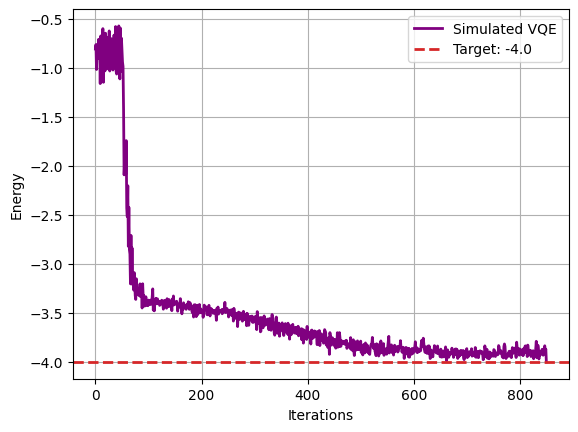

In [31]:
#Plot the Results
intermediate_info_aux = [intermediate_info[i][0] for i in range(len(intermediate_info))]
plt.plot(intermediate_info_aux, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=ref_value, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.legend()
plt.grid()
plt.show()

To check for the optimal number of layers we define a basic score function and progressively increase the number of layers

In [32]:
def Score(ansatz, noise):
    
    e = 0
    
    for j in range(3):
        # Define instance of qiskit-terra's Estimator primitive
        challenge_sampling = ChallengeSampling(noise=noise)

        sampling_estimator = (
            challenge_sampling.create_concurrent_parametric_sampling_estimator(
            n_shots, measurement_factory, shots_allocator, hardware_type))

        estimator = sampling_estimator

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, spsa, callback=callback)
        
        result = custom_vqe.compute_minimum_eigenvalue(hamiltonian)
        
        e += abs(result.eigenvalue-ref_value)
        
    e = e/3
    
    return 1/e

In [34]:
import warnings
warnings.filterwarnings("ignore")

for l in range(1, 6):
    score = Score(mansatz(l,4), False)
    
    print('LAYERS: ', l, 'SCORE: ', score)

LAYERS:  1 SCORE:  1.4297461872399677
LAYERS:  2 SCORE:  2.0583682297139902
LAYERS:  3 SCORE:  12.21837302734907
LAYERS:  4 SCORE:  7.606769031108851
LAYERS:  5 SCORE:  11.445916054794278


Note that these scores can be substentially increased by increasing the number of shots (which will increase computing costs). But from this example we can see that the best number of layers is 3. This, combined with the fact that increasing layers will produce more noise led us to choose 3 layers 

We can also verify that this Ansatz works for the remaining orbital rotated Hamiltonians

In [35]:
n_site = 2 #4
n_qubits = 2 * n_site
ham2 = load_operator(
    file_name=f"{n_qubits}_qubits_H_2",
    data_directory="../hamiltonian/hamiltonian_samples",
    plain_text=False,
)
jw_hamiltonian2 = jordan_wigner(ham2)
hamiltonian2 = operator_from_openfermion_op(jw_hamiltonian2)

intermediate_info = []
def callback(value, x):
        intermediate_info.append([value,[x]])
        
        
sampling_estimator = (
    challenge_sampling.create_concurrent_parametric_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

estimator = sampling_estimator

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator,  mansatz(3,4), spsa, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(hamiltonian2)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 800,
    'eigenstate': None,
    'eigenvalue': -4.006471964144322,
    'optimal_circuit': None,
    'optimal_parameters': array([-0.08377646,  3.70236786,  1.87135205,  1.58797967, -0.05735325,
        3.69949982, -1.92968201, -0.12466916,  0.65938122,  2.99777986,
       -0.09981978,  1.75103992, -1.69134996,  2.13929871,  0.22307481,
        2.21594293,  3.09496016, -0.02514034, -3.15408408,  3.10224333]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 15.44


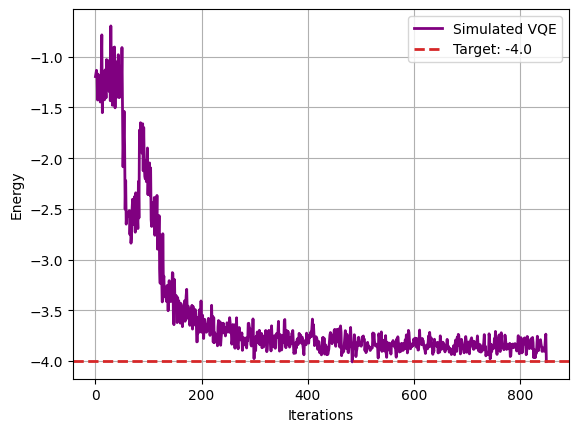

In [36]:
#Plot the results
intermediate_info_aux = [intermediate_info[i][0] for i in range(len(intermediate_info))]
plt.plot(intermediate_info_aux, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=ref_value, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.legend()
plt.grid()
plt.show()

We now need to take in consideration noise. To cut through noise, we used Zero Noise Extrapolation techniques. We also have to take in consideration the variance of the estimator. For instance, if we do not consider noise and take a more modest number of shots, for example n_shots = 1024, we see the following

VAR:  0.2054304452290343
AVER:  -3.929053059474822


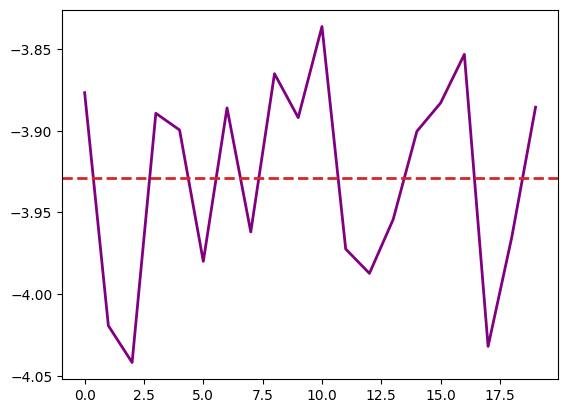

In [37]:
x0 = min(intermediate_info)[1][0]

challenge_sampling = ChallengeSampling(noise=False)
n_shots = 2048
sampling_estimator = (
    challenge_sampling.create_concurrent_parametric_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

estimator = sampling_estimator
aux_l = []
aqui = 0
for i in range(20):
    est = estimator(hamiltonian, mansatz(3,4), [x0])
    aux_l.append(est[0].value.real)
    aqui += aux_l[-1]
    
print('VAR: ', max(aux_l)-min(aux_l))
print('AVER: ', aqui/20)
plt.plot(aux_l, color='purple', lw=2)
plt.axhline(y=aqui/20, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.show()

As we can see there is a bit of variance in the estimator. If we include noise, this problem becomes even worse

VAR:  2.167675658217409
AVER:  -2.932861948066499


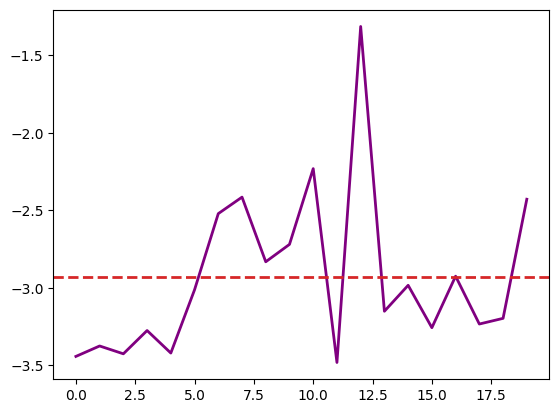

In [58]:
challenge_sampling = ChallengeSampling(noise=True)
n_shots = 2048
sampling_estimator = (
    challenge_sampling.create_concurrent_parametric_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

estimator = sampling_estimator

Y_ZNE = []
aux_l = []
aqui = 0
for i in range(20):
    est = estimator(hamiltonian, mansatz(3,4), [x0])
    aux_l.append(est[0].value.real)
    aqui += aux_l[-1]
    
Y_ZNE.append(aqui/20)
print('VAR: ', max(aux_l)-min(aux_l))
print('AVER: ', aqui/20)
plt.plot(aux_l, color='purple', lw=2)
plt.axhline(y=aqui/20, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.show()

To counter this we repeat each estimation multiple times, given that the averages vary much less.

VAR:  2.279523926637003
AVER:  -2.8439871874880405


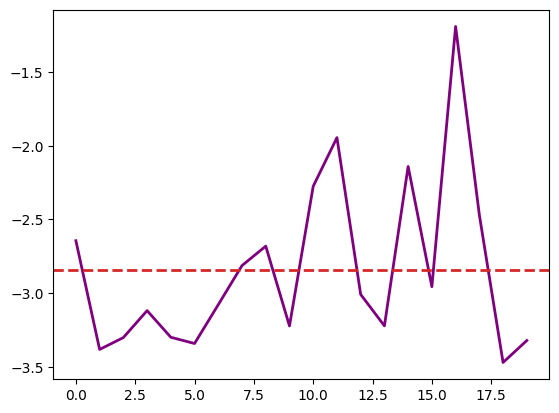

In [42]:
aux_l = []
aqui = 0
for i in range(20):
    est = estimator(hamiltonian, mansatz(3,4), [x0])
    aux_l.append(est[0].value.real)
    aqui += aux_l[-1]
    
print('VAR: ', max(aux_l)-min(aux_l))
print('AVER: ', aqui/20)
plt.plot(aux_l, color='purple', lw=2)
plt.axhline(y=aqui/20, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.show()

Now we can start building the ZNE into the VQE. To do so we use a new Ansatz proper for ZNE:

In [43]:
def mansatz_ZNE(l, n, par, k, s):
    
    #l - number of layers
    #n - number of qubits
    #par - parameters
    #k - folding value
    #s - fraction of folding
    
    if k%2 != 1:
        print('ERROR in ZNE')
        
    else:

        ans = QuantumCircuit(n)
        
        if n == 4:
            ans.x(2)
            ans.x(3)
        elif n == 8:
            ans.x(4)
            ans.x(5)
            ans.x(6)
            ans.x(7)
        
        if s > k:
            print('ERROR in FOLDING')

        for layer in range(l):
            
            if s == -1:
                for j in range(n):
                    ans.ry( par[layer*n+j], j)
                for j in range(n-1):
                    ans.cx(j, j+1)
                
            elif layer < s:
            
                for i in range(k):
                    for j in range(n):
                        if i%2 == 0:
                            ans.ry( par[layer*n+j], j)
                        else:
                            ans.ry( -par[layer*n+j], j)
                for j in range(n-1):
                    for i in range(k):
                        ans.cx(j, j+1)
            else:
                for j in range(n):
                    ans.ry( par[layer*n+j], j)
                for j in range(n-1):
                    ans.cx(j, j+1)

        for i in range(k):
            for j in range(n):
                if i %2 == 0:
                    ans.rz(par[-2*n+j], j)
                else:
                    ans.rz(-par[-2*n+j], j)

        for i in range(k):
            for j in range(n):
                if i %2 == 0:
                    ans.ry(par[-n+j], j)
                else:
                    ans.ry(-par[-n+j], j)

        return ans    

Because we are only interested in points close to the zero noise regime, we only fold 1 layer of the ansatz and use a linear extrapolatio.

In [44]:
mansatz_ZNE(3,4,x0, 3, 1).draw(fold=300)

┌──────────────┐┌─────────────┐┌──────────────┐                        ┌───────────────┐                             ┌─────────────┐                                                   ┌─────────────┐┌────────────┐┌─────────────┐   ┌────────────┐ ┌─────────────┐   ┌────────────┐                 »
q_0: ┤ Ry(-0.21847) ├┤ Ry(0.21847) ├┤ Ry(-0.21847) ├──────■─────────■────■──┤ Ry(0.0083584) ├──────────────────────────■──┤ Ry(0.84299) ├──────────────────────────────────────────■────────┤ Rz(-1.7481) ├┤ Rz(1.7481) ├┤ Rz(-1.7481) ├───┤ Ry(3.0664) ├─┤ Ry(-3.0664) ├───┤ Ry(3.0664) ├─────────────────»
     └┬────────────┬┘├─────────────┤└┬────────────┬┘    ┌─┴─┐     ┌─┴─┐┌─┴─┐└───────────────┘          ┌────────────┐┌─┴─┐└─────────────┘                     ┌────────────┐     ┌─┴─┐      └─────────────┘├───────────┬┘└┬────────────┤   ├───────────┬┘ ├─────────────┴┐┌─┴────────────┴┐┌──────────────┐»
q_1: ─┤ Ry(3.8167) ├─┤ Ry(-3.8167) ├─┤ Ry(3.8167) ├─────┤ X ├─────┤ X ├┤ X ├────────■──────────■────■──┤ Ry(3.6348) ├┤ X ├─────────────────────────────────■──┤ Ry(3.0399) ├─────┤ X ├─────────────■───────┤ Rz(2.297) ├──┤ Rz(-2.297) ├───┤ Rz(2.297) ├──┤ Ry(0.044889) ├┤ Ry(-0.044889) ├┤ Ry(0.044889) ├»
      └───┬───┬────┘ └┬────────────┤┌┴────────────┤ ┌───┴───┴────┐└───┘└───┘      ┌─┴─┐      ┌─┴─┐┌─┴─┐└────────────┘└───┘               ┌─────────────┐ ┌─┴─┐└────────────┘┌────┴───┴─────┐     ┌─┴─┐     └───────────┘ ┌┴────────────┴┐┌─┴───────────┴─┐├──────────────┤└┬─────────────┬┘└┬────────────┬┘»
q_2: ─────┤ X ├───────┤ Ry(1.8551) ├┤ Ry(-1.8551) ├─┤ Ry(1.8551) ├────────────────┤ X ├──────┤ X ├┤ X ├──────■─────────■─────────■───────┤ Ry(-1.9744) ├─┤ X ├──────■───────┤ Ry(-0.11936) ├─────┤ X ├───────────■───────┤ Rz(0.099337) ├┤ Rz(-0.099337) ├┤ Rz(0.099337) ├─┤ Ry(-3.1777) ├──┤ Ry(3.1777) ├─»
          ├───┤       ├────────────┤├─────────────┤ ├────────────┤                └───┘      └───┘└───┘    ┌─┴─┐     ┌─┴─┐     ┌─┴─┐     ├─────────────┴┐└───┘    ┌─┴─┐     └┬────────────┬┘     └───┘         ┌─┴─┐     └┬────────────┬┘└┬─────────────┬┘└┬────────────┬┘ └┬────────────┤ ┌┴────────────┤ »
q_3: ─────┤ X ├───────┤ Ry(1.7237) ├┤ Ry(-1.7237) ├─┤ Ry(1.7237) ├─────────────────────────────────────────┤ X ├─────┤ X ├─────┤ X ├─────┤ Ry(-0.10861) ├─────────┤ X ├──────┤ Ry(1.6464) ├────────────────────┤ X ├──────┤ Rz(2.3749) ├──┤ Rz(-2.3749) ├──┤ Rz(2.3749) ├───┤ Ry(3.2683) ├─┤ Ry(-3.2683) ├─»
          └───┘       └────────────┘└─────────────┘ └────────────┘                                         └───┘     └───┘     └───┘     └──────────────┘         └───┘      └────────────┘                    └───┘      └────────────┘  └─────────────┘  └────────────┘   └────────────┘ └─────────────┘ »
«                    
«q_0: ───────────────
«                    
«q_1: ───────────────
«     ┌─────────────┐
«q_2: ┤ Ry(-3.1777) ├
«     └┬────────────┤
«q_3: ─┤ Ry(3.2683) ├
«      └────────────┘

VAR:  1.4300563279346952
AVER:  -2.5282208009745735


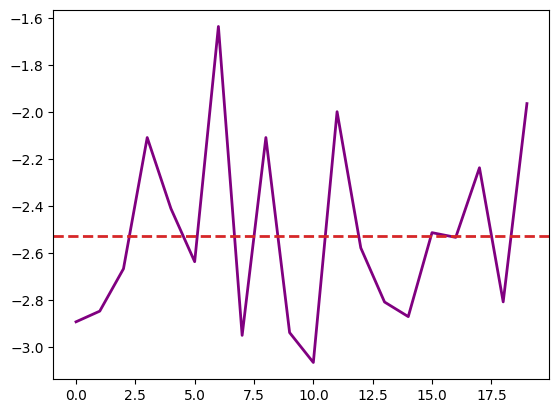

In [59]:
ZNE_sampling_estimator = (
    challenge_sampling.create_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

aux_l = []
aqui = 0
for i in range(20):
    est = ZNE_sampling_estimator(hamiltonian, mansatz_ZNE(3,4,x0, 3,1))
    aux_l.append(est.value.real)
    aqui += aux_l[-1]
    
print('VAR: ', max(aux_l)-min(aux_l))
print('AVER: ', aqui/20)
Y_ZNE.append(aqui/20)
plt.plot(aux_l, color='purple', lw=2)
plt.axhline(y=aqui/20, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.show()

And we can now build our model:

In [61]:
x = [1,1.5]
model = np.poly1d(np.polyfit(x,Y_ZNE, 1))
print(model)
print(model(0))
y_min = model(0)

 
0.8093 x - 3.742
-3.74214424225035


The extrapolated value is now corrected and much closer to the desired value. We now put everything together in a new VQE class which will take advantage of both ZNE and VQE natural resistance against noise. We used this simple and somewhat limited ZNE method due to the restraints in the number of shots

In [64]:
class CustomVQE_ZNE(MinimumEigensolver):
    
    def __init__(self, estimator, estimatorZNE, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._estimatorZNE = estimatorZNE
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            #job = self._estimator.run([self._circuit], [operators], [x])

            x_axis = [1,1.5]
            aux_ZNE = []
            aux_n = 0
            
            for i in range(10):
                job = self._estimator(operators, self._circuit, [x])
                aux_n += job[0].value.real 
                
            aux_n = aux_n/10
            
            aux_ZNE.append(aux_n)
            
            aux_n = 0
            
            for i in range(10):
                est = self._estimatorZNE(operators, mansatz_ZNE(3,n_qubits,x, 3,1))
                aux_n += est.value.real
                
            aux_n = aux_n/10
            aux_ZNE.append(aux_n)
            
            
            model = np.poly1d(np.polyfit(x_axis, aux_ZNE, 1))
            value = model(0)

            # Save result information using callback function
            if self._callback is not None:
                self._callback(value, x)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        try:
            res = self._optimizer.minimize(objective, x0=x0)
            result = VQEResult()
            result.cost_function_evals = res.nfev
            result.eigenvalue = res.fun
            result.optimal_parameters = res.x
            
        except TimeExceededError:
            result = 0
            print("Reached the limit of shots")
        
        # Populate VQE result

        return result

We can now run our algorithm. Warning, this can take several hours

In [65]:
# Define a simple callback function
intermediate_info = []
def callback(value, x):
    intermediate_info.append([value,[x]])


hardware_type = 'sc'
shots_allocator = create_proportional_shots_allocator()
measurement_factory = bitwise_commuting_pauli_measurement
n_shots = 512

sampling_estimator = (
    challenge_sampling.create_concurrent_parametric_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

estimator = sampling_estimator

ZNE_sampling_estimator = (
    challenge_sampling.create_sampling_estimator(
    n_shots, measurement_factory, shots_allocator, hardware_type))

# Setup VQE algorithm
custom_vqe = CustomVQE_ZNE(estimator, ZNE_sampling_estimator, mansatz(3,n_qubits), spsa, callback=callback)

start = time()
result = custom_vqe.compute_minimum_eigenvalue(hamiltonian)
end = time()

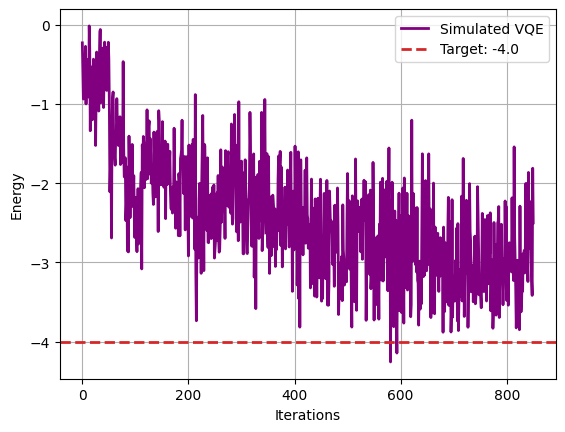

In [66]:
#Plot the Results
intermediate_info_aux = [intermediate_info[i][0] for i in range(len(intermediate_info))]
plt.plot(intermediate_info_aux, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=ref_value, color="tab:red", ls="--", lw=2, label="Target: " + str(ref_value))
plt.legend()
plt.grid()
plt.show()

Given these rults, we devised 2 methods. The first method is to average the minimum energies obtained through the parameters spammed by our VQE 

In [72]:
aux_inter_info = intermediate_info_aux.copy()
aux_ll = []
for i in range(7):
    aux_ll.append(min(aux_inter_info))
    aux_inter_info.remove(min(aux_inter_info))

average = 0
for kk in aux_ll:
    average += kk

average /=7

print('METHOD 1 ', average)
print('SCORE: ', 1/abs(average-ref_value))

METHOD 1  -3.9565262979947726
SCORE:  23.002411892130965


The second method consists of taking the absolute minimum of the energies obtained and to perform more extensive ZNE with more data points

In [74]:
Y = []
aqui = 0
for i in range(20):
    est = ZNE_sampling_estimator(hamiltonian, mansatz_ZNE(3,4,x0, 1,1))
    aux_l.append(est.value.real)
    aqui += aux_l[-1]

Y.append(aqui/20)

aqui = 0
for i in range(20):
    est = ZNE_sampling_estimator(hamiltonian, mansatz_ZNE(3,4,x0, 3,3))
    aux_l.append(est.value.real)
    aqui += aux_l[-1]

Y.append(aqui/20)

aqui = 0
for i in range(20):
    est = ZNE_sampling_estimator(hamiltonian, mansatz_ZNE(3,4,x0, 5,5))
    aux_l.append(est.value.real)
    aqui += aux_l[-1]

Y.append(aqui/20)


METHOD 2  -3.6514470550805758
Score:  2.869004593351441


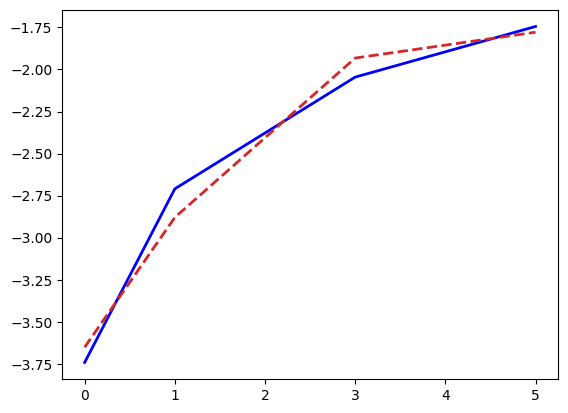

In [76]:
xx = [0]+[1,3,5]

model = np.poly1d(np.polyfit(xx, [y_min]+Y, 2))

plt.plot(xx, [y_min]+Y, color='blue', lw=2)
plt.plot(xx, model(xx), color="tab:red", ls="--", lw=2)

print('METHOD 2 ', model(0))
print('Score: ', 1/abs(model(0)-ref_value))

As we can see the Score of method 1 was much higher and therefore that was the one selected in our project. To obtain the final score all that is left is to change to the 8 qubit Hamiltonian. In the file answer.py, our final answer to this problem can be found. 